# Sampling beyond Metropolis-Hastings — a (toy) case study

Here, we'll study the case of the very simple model
\[
d_i = \mu + n_i
\]

where *s* is a constant, and the $n_i$ are zero-mean noise terms with a constant but __unknown__ variance $\sigma^2$.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt

## both of these can be installed with `pip` if you don't already have them
import pystan
import getdist
import getdist.plots


%matplotlib inline

# Simulate data from this model

\begin{equation}
d_i \sim \textrm{Normal}(\mu, \sigma)
\end{equation}

## Pick some parameters

In [2]:
sigma = 0.5
mu = 1.0

ndat = 12   ### can still make inferences with relatively small amount of data

## Generate data

In [3]:
dat = sps.norm.rvs(loc=mu, scale=sigma, size=ndat)   ## random variates

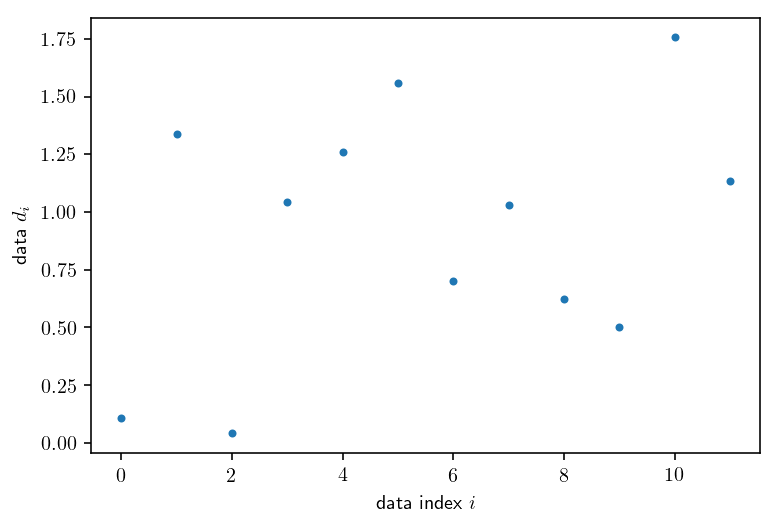

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.plot(dat, '.')
_ = ax.set_xlabel(r"data index $i$")
_ = ax.set_ylabel(r"data $d_i$")

### Summary statistics

In [5]:
d_bar = dat.mean()
d2_bar = (dat**2).mean()
var_d = ((dat-d_bar)**2).mean()
print(f"E(d)={d_bar:5.4}; E(d^2)={d2_bar:5.4}")
print(f"var(d)={var_d:5.4}; var(d)^{1/2}={np.sqrt(var_d):5.4}")

E(d)=0.924; E(d^2)=1.121
var(d)=0.2677; var(d)^0.5=0.5174


### Posterior

This is a case where we actually know the shape of the posterior and can calculate everything analytically

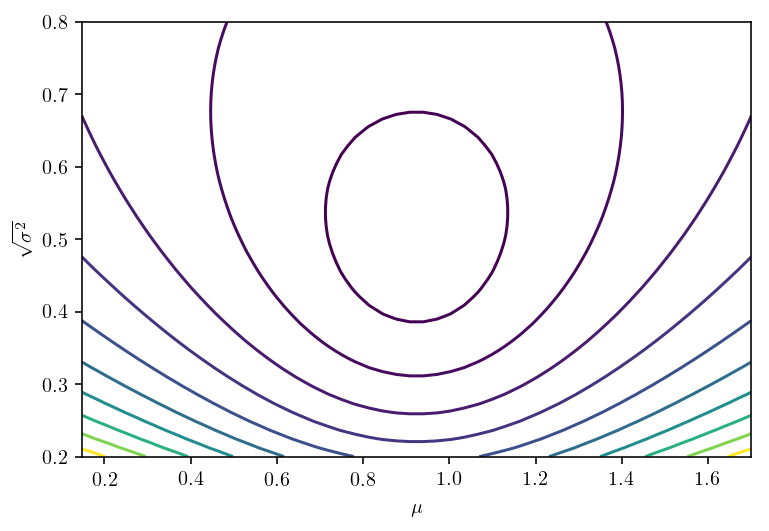

In [6]:
def lnpost(mu, sig):
    sig2 = sig**2
    prior = 1/sig
    loglike = -(ndat/2)*(np.log(2*np.pi*sig2) + (d2_bar - 2*mu*d_bar + mu**2)/sig2)
    return np.log(prior)+loglike

fig = plt.figure()
ax = fig.add_subplot(111)
mus = np.linspace(d_bar-1.5*np.sqrt(var_d), d_bar+1.5*np.sqrt(var_d))
sigs = np.linspace(0.2, 0.8)
x,y = np.meshgrid(mus, sigs)

lnposts = lnpost(x,y)
lnposts -= lnposts.max()

_ = ax.contour(x,y,-lnposts, np.arange(20)**2)
_ = ax.set_xlabel(r"$\mu$")
_ = ax.set_ylabel(r"$\sqrt{\sigma^2}$")


## Gibbs sampling

We also know the conditionals, so Gibbs sampling is very easy to implement (and because there is no very strong covariance, **_at least near the peak_**, it is pretty efficient at exploring the posterior)

In [7]:
nsamples = 200
mu_samples = []
sigma2_samples = []

mu_1 = 0.0  ## starting point

for _ in range(nsamples):
    
    ### Inverse Gamma parameters
    a = (ndat-1)/2
    scale = (ndat/2)*(d2_bar - 2*mu_1*d_bar + mu_1**2)
    
    sigma2_1 = sps.invgamma.rvs(a, scale=scale)
    mu_1 = sps.norm.rvs(d_bar, np.sqrt(sigma2_1/ndat))
    
    sigma2_samples.append(sigma2_1)
    mu_samples.append(mu_1)
    
burn = 10   ## discard some samples from the beginning
mu_samples = np.asarray(mu_samples[burn:])
sigma2_samples = np.asarray(sigma2_samples[burn:])

#### Simple statistics for our samples (*not* the data!)

In [8]:
print(f"E(mu)={mu_samples.mean():5.4}")
print(f"E(sigma2)^{1/2}={np.sqrt(sigma2_samples.mean()):5.4}")

E(mu)=0.9398
E(sigma2)^0.5=0.6157


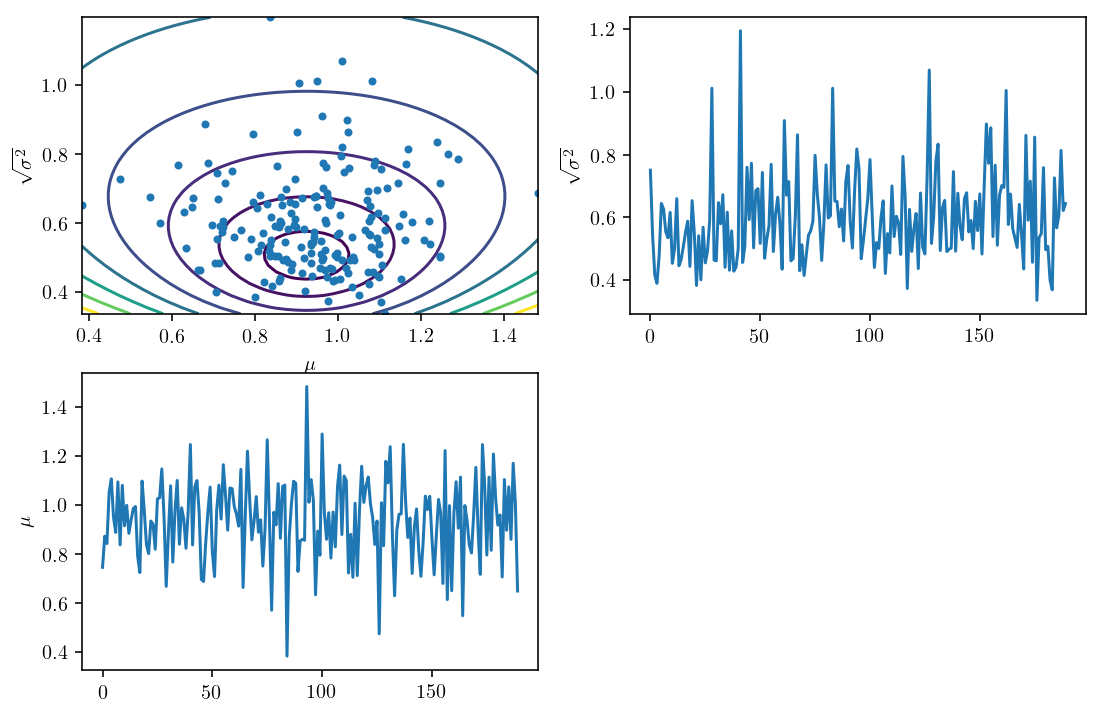

In [9]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(221)

### plot the contours of the *true* distribution
mus = np.linspace(mu_samples.min(), mu_samples.max())
sigs = np.linspace(np.sqrt(sigma2_samples.min()), np.sqrt(sigma2_samples.max()))
x,y = np.meshgrid(mus, sigs)
lnposts = lnpost(x,y)
lnposts -= lnposts.max()

### Plot the samples
_ = ax.plot(mu_samples, np.sqrt(sigma2_samples), '.')
_ = ax.set_xlabel(r"$\mu$")
_ = ax.set_ylabel(r"$\sqrt{\sigma^2}$")
_ = ax.contour(x,y,-lnposts, 0.25*np.arange(20)**2)

### Plot the traces
ax = fig.add_subplot(223)
_ = ax.plot(mu_samples)
_ = ax.set_ylabel(r"$\mu$")

ax = fig.add_subplot(222)
_ = ax.plot(np.sqrt(sigma2_samples))
_ = ax.set_ylabel(r"$\sqrt{\sigma^2}$")

Can also use Antony Lewis' `getdist` package to make nice plots for us.

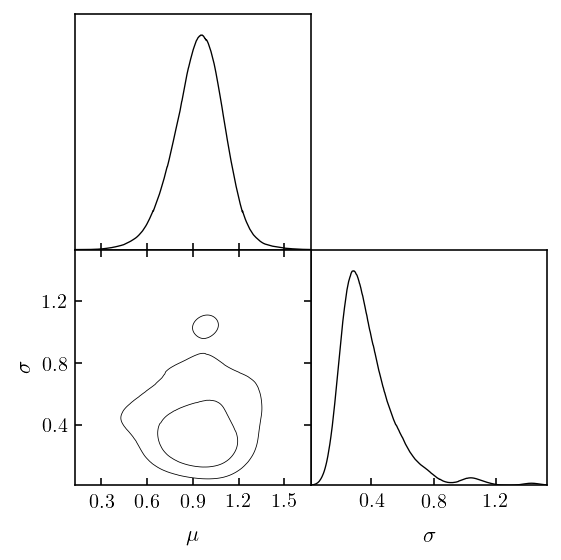

In [10]:
### convert samples to getdist format
gd = getdist.MCSamples(samples=[mu_samples, sigma2_samples], labels=[r'$\mu$', r'$\sigma$'])
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(gd)

## HMC using stan  <http://mc-stan.org>

In [11]:
stan_code="""
// these quantities come from outside
data {
    int n;
    vector[n] dat;
}

// this is what we want to estimate
parameters {
    real mu;
    real<lower=0> sigma;
}

// this is what we need for the prior and the likelihood
// (stan defaults to uniform for real numbers without bounds
//  and [I think!] log-uniform for quantities with a lower bound)
// so all we need to specify is the likelihood
model {
    dat ~ normal(mu, sigma);
}
"""

In [12]:
stan_dat = {
    'n': ndat,
    'dat': dat
}

### A few useful utilities for running Stan and working with Stan output.

In [13]:
from six import iteritems
def pystan2getdist(fit, texdict={}):
    """ convert a pystan fit object into an A Lewis MCSamples object                                                                                                      
        texdict is a dictionary mapping from stan parameter names to latex labels, if desired                                                                             
    """

    ### have to either deal with combining chains (permute=False)                                                                                                         
    ###                       or separating vector-valued parameters (permute=True)                                                                                       

    sample_dict = fit.extract(permuted=True)
    names = []
    labels = []
    samples = []
    for par, samps in iteritems(sample_dict):
        if par == "lp__":
            loglikes = -samps
        else:
            if len(samps.shape)==1:
                names.append(par)
                labels.append(texdict.get(par,par))
                samples.append(samps)
            else:
                for i,s in enumerate(samps.T):
                    samples.append(s)
                    names.append(par+str(i+1))

                    labels.append(texdict.get(par,par)+"_"+str(i+1))

    return getdist.MCSamples(names=labels, samples=samples, loglikes=loglikes, labels=labels)

In [14]:
import pickle
def StanModel_cache(model_code=None, stanc_ret=None, model_name=None, **kwargs):
    """
    Code to cache models to avoid recompilation.
    Use just as you would `pystan.StanModel`. 
    From the pystan docs. 
    """
    if model_code is not None:
        code_hash = md5(model_code.encode('ascii')).hexdigest()

        if model_name is None:
            cache_fn = 'cached-model-{}.pkl'.format(code_hash)
        else:
            cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)

    elif stanc_ret is not None:
        cache_fn = stanc_ret['model_cppname']+'.pkl'

    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code, stanc_ret=stanc_ret, **kwargs)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

## Compile the model if needed

In [15]:
stanc_ret = pystan.stanc(model_code=stan_code, model_name='gauss_var')
stan_model = StanModel_cache(stanc_ret=stanc_ret)

Using cached StanModel


In [16]:
fit = stan_model.sampling(data=stan_dat, chains=4)

In [17]:
print(fit)

Inference for Stan model: gauss_var_d3810c48a9c38712f31674e7c5741fe4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.92  3.9e-3   0.18   0.55    0.8   0.92   1.04   1.27   2275    1.0
sigma   0.62  3.3e-3   0.15    0.4   0.51   0.59    0.7   0.98   2080    1.0
lp__    0.18    0.03   1.05  -2.65  -0.23   0.49   0.94   1.24   1366    1.0

Samples were drawn using NUTS at Wed Sep  5 13:46:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


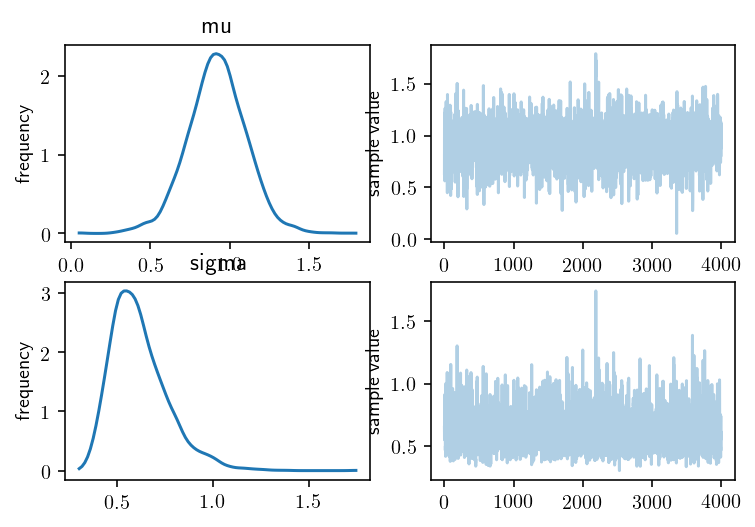

In [18]:
_ = fit.plot()

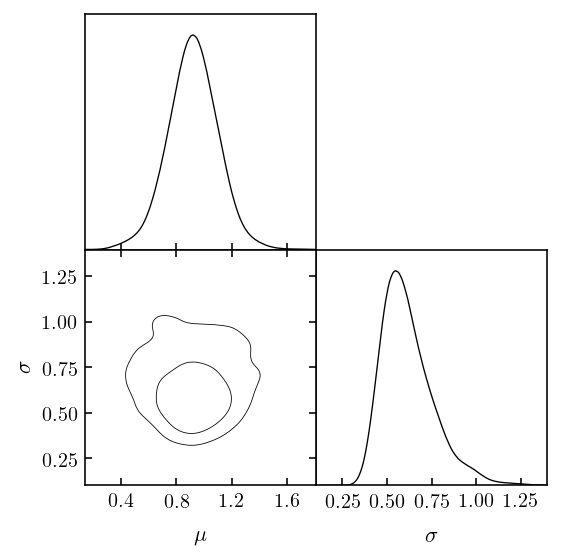

In [19]:
### some homegrown code to convert pystan output to GetDist format (available on request)
gd1 = pystan2getdist(fit, texdict={'mu': r'$\mu$', 'sigma': r'$\sigma$'})
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(gd1)

### Run some diagnostics (requires lates `pystan`)

Should all evaluate to `true`.

In [20]:
pystan.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}